# Traffic Forecasting Comparison: XGBoost vs SARIMA vs LSTM

## Overview
การเปรียบเทียบประสิทธิภาพของโมเดลการพยากรณ์การจราจร 3 วิธี:
1. **XGBoost** - Gradient Boosting Model
2. **SARIMA** - Seasonal Autoregressive Integrated Moving Average
3. **LSTM** - Long Short-Term Memory Neural Network

Dataset: Traffic data with features including vehicle count, lags, day of week, hour, and target for next hour prediction.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning models
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Time series analysis
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

2025-09-10 23:17:00.333785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All libraries imported successfully!
TensorFlow version: 2.20.0
XGBoost version: 3.0.5


## 1. Data Loading and Exploration

In [3]:
# Load the dataset
df = pd.read_csv('traffic_dataset1.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (310917, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 310917 entries, 2016-09-13 21:05:00 to 2019-09-23 11:45:00
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   vehicle_count   310917 non-null  int64 
 1   lag_1           310917 non-null  int64 
 2   lag_2           310917 non-null  int64 
 3   lag_3           310917 non-null  int64 
 4   day_of_week     310917 non-null  object
 5   hour            310917 non-null  int64 
 6   target_next_1h  310917 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 19.0+ MB
None

First few rows:
                     vehicle_count  lag_1  lag_2  lag_3 day_of_week  hour  \
timestamp                                                                   
2016-09-13 21:05:00              1      4     10      2     Tuesday    21   
2016-09-13 21:10:00              5      1      4     10     Tuesday    21   
2016-09-13 21:15:00         

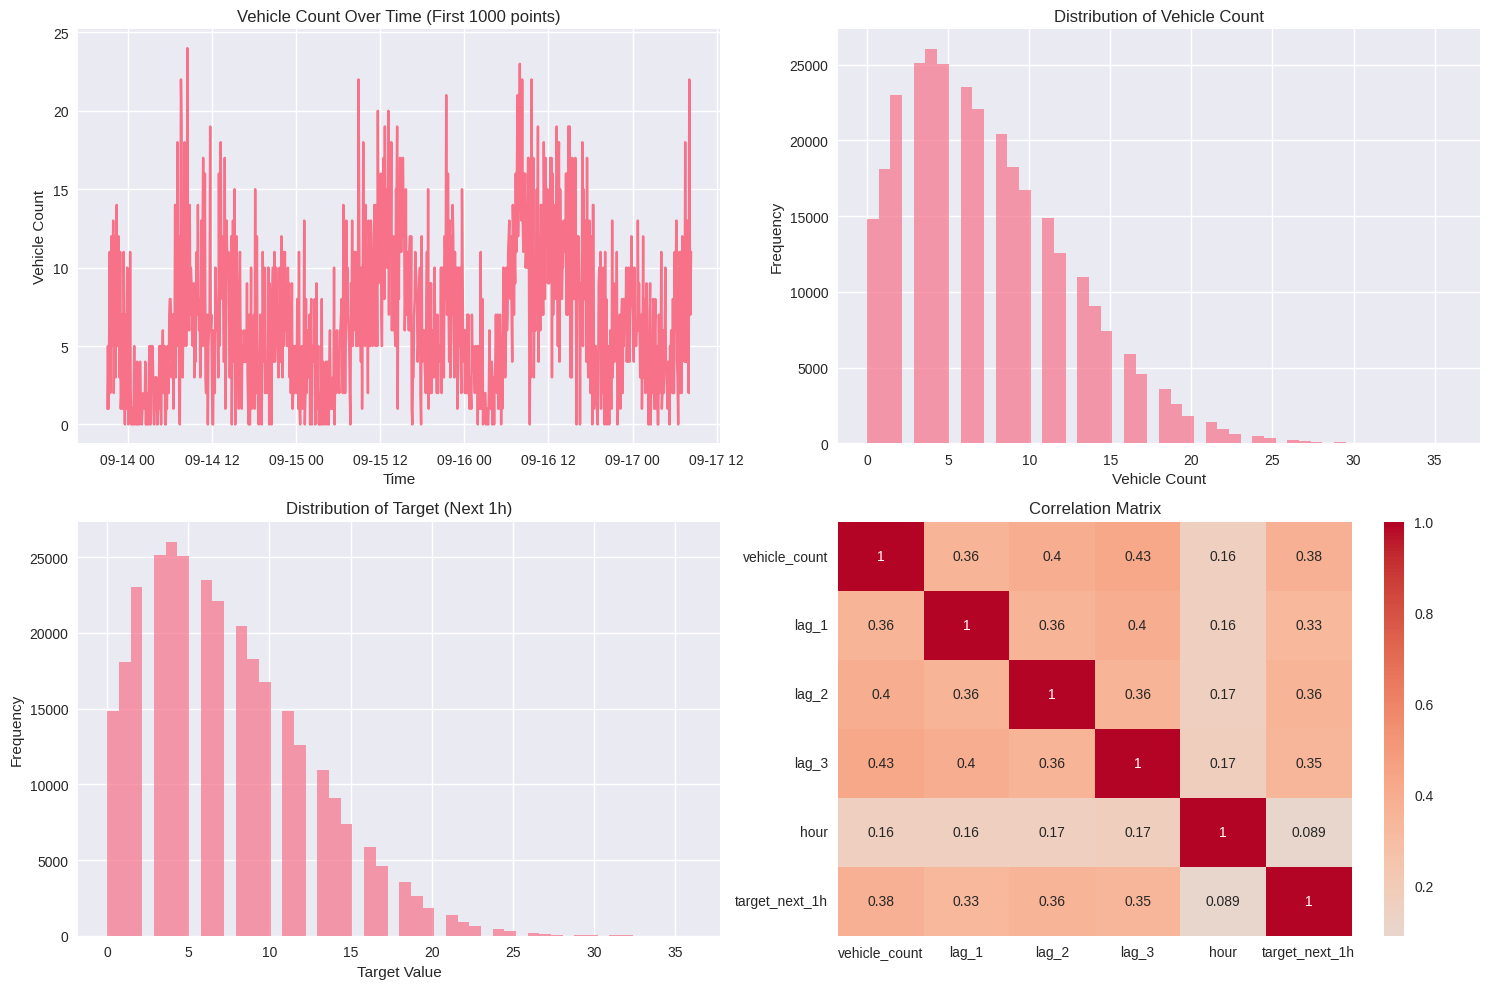

Missing values:
vehicle_count     0
lag_1             0
lag_2             0
lag_3             0
day_of_week       0
hour              0
target_next_1h    0
dtype: int64


In [3]:
# Data visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Vehicle count over time (sample of first 1000 points)
axes[0,0].plot(df['vehicle_count'][:1000])
axes[0,0].set_title('Vehicle Count Over Time (First 1000 points)')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Vehicle Count')

# Distribution of vehicle count
axes[0,1].hist(df['vehicle_count'], bins=50, alpha=0.7)
axes[0,1].set_title('Distribution of Vehicle Count')
axes[0,1].set_xlabel('Vehicle Count')
axes[0,1].set_ylabel('Frequency')

# Target variable distribution
axes[1,0].hist(df['target_next_1h'], bins=50, alpha=0.7)
axes[1,0].set_title('Distribution of Target (Next 1h)')
axes[1,0].set_xlabel('Target Value')
axes[1,0].set_ylabel('Frequency')

# Correlation heatmap
numeric_cols = ['vehicle_count', 'lag_1', 'lag_2', 'lag_3', 'hour', 'target_next_1h']
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
axes[1,1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

## 2. Data Preprocessing

In [4]:
# Data preprocessing
# Encode categorical variables
df_encoded = df.copy()

# One-hot encode day_of_week
day_dummies = pd.get_dummies(df['day_of_week'], prefix='day')
df_encoded = pd.concat([df_encoded, day_dummies], axis=1)
df_encoded.drop('day_of_week', axis=1, inplace=True)

print("Dataset shape after encoding:", df_encoded.shape)
print("Columns:", df_encoded.columns.tolist())

# Check data range
print("\nData range check:")
print(f"Target range: {df_encoded['target_next_1h'].min()} to {df_encoded['target_next_1h'].max()}")
print(f"Vehicle count range: {df_encoded['vehicle_count'].min()} to {df_encoded['vehicle_count'].max()}")

Dataset shape after encoding: (310917, 13)
Columns: ['vehicle_count', 'lag_1', 'lag_2', 'lag_3', 'hour', 'target_next_1h', 'day_Friday', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday', 'day_Wednesday']

Data range check:
Target range: 0 to 36
Vehicle count range: 0 to 36


In [5]:
# Train-test split
# Use 80% for training, 20% for testing
split_point = int(len(df_encoded) * 0.8)

# Features and target
feature_cols = [col for col in df_encoded.columns if col != 'target_next_1h']
X = df_encoded[feature_cols]
y = df_encoded['target_next_1h']

# Time series split (chronological order)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training period: {X_train.index[0]} to {X_train.index[-1]}")
print(f"Test period: {X_test.index[0]} to {X_test.index[-1]}")

# For SARIMA, we'll use only the vehicle_count time series
ts_train = df['vehicle_count'].iloc[:split_point]
ts_test = df['vehicle_count'].iloc[split_point:]

Training set size: 248733
Test set size: 62184
Training period: 2016-09-13 21:05:00 to 2019-02-17 13:15:00
Test period: 2019-02-17 13:20:00 to 2019-09-23 11:45:00


## 3. Model 1: XGBoost

In [6]:
# XGBoost Model Training
print("Training XGBoost model...")

# Initialize and train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_pred = xgb_model.predict(X_test)

# Calculate metrics
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost Results:")
print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R²: {xgb_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))

Training XGBoost model...
XGBoost Results:
RMSE: 3.8179
MAE: 3.0057
R²: 0.2228

Top 10 Feature Importances:
          feature  importance
4            hour    0.695695
8      day_Sunday    0.063748
0   vehicle_count    0.063293
2           lag_2    0.051080
3           lag_3    0.035793
7    day_Saturday    0.032254
1           lag_1    0.016044
5      day_Friday    0.014005
6      day_Monday    0.008572
11  day_Wednesday    0.008144
XGBoost Results:
RMSE: 3.8179
MAE: 3.0057
R²: 0.2228

Top 10 Feature Importances:
          feature  importance
4            hour    0.695695
8      day_Sunday    0.063748
0   vehicle_count    0.063293
2           lag_2    0.051080
3           lag_3    0.035793
7    day_Saturday    0.032254
1           lag_1    0.016044
5      day_Friday    0.014005
6      day_Monday    0.008572
11  day_Wednesday    0.008144


## 4. Model 2: SARIMA

In [ ]:
# SARIMA Model Training
print("Training SARIMA model...")

# Use a subset of data for SARIMA due to computational constraints
# Take every 12th point (hourly data instead of 5-minute data)
ts_train_hourly = ts_train[::12]
ts_test_hourly = ts_test[::12]

print(f"SARIMA training data size: {len(ts_train_hourly)}")
print(f"SARIMA test data size: {len(ts_test_hourly)}")

try:
    # Fit SARIMA model with seasonal parameters
    # Using simple parameters to avoid overly complex computation
    sarima_model = SARIMAX(
        ts_train_hourly,
        order=(1, 1, 1),  # (p, d, q)
        seasonal_order=(1, 1, 1, 24),  # (P, D, Q, S) - 24 hours seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    sarima_fitted = sarima_model.fit(disp=False)
    
    # Make predictions
    sarima_pred = sarima_fitted.forecast(steps=len(ts_test_hourly))
    
    # Calculate metrics (using hourly test data)
    sarima_mse = mean_squared_error(ts_test_hourly, sarima_pred)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mae = mean_absolute_error(ts_test_hourly, sarima_pred)
    sarima_r2 = r2_score(ts_test_hourly, sarima_pred)
    
    print(f"SARIMA Results (Hourly Data):")
    print(f"RMSE: {sarima_rmse:.4f}")
    print(f"MAE: {sarima_mae:.4f}")
    print(f"R²: {sarima_r2:.4f}")
    
    sarima_success = True
    
except Exception as e:
    print(f"SARIMA training failed: {str(e)}")
    print("Using simple ARIMA model instead...")
    
    # Fallback to simple ARIMA
    try:
        arima_model = ARIMA(ts_train_hourly, order=(2, 1, 2))
        arima_fitted = arima_model.fit()
        
        sarima_pred = arima_fitted.forecast(steps=len(ts_test_hourly))
        
        sarima_mse = mean_squared_error(ts_test_hourly, sarima_pred)
        sarima_rmse = np.sqrt(sarima_mse)
        sarima_mae = mean_absolute_error(ts_test_hourly, sarima_pred)
        sarima_r2 = r2_score(ts_test_hourly, sarima_pred)
        
        print(f"ARIMA Results (Hourly Data):")
        print(f"RMSE: {sarima_rmse:.4f}")
        print(f"MAE: {sarima_mae:.4f}")
        print(f"R²: {sarima_r2:.4f}")
        
        sarima_success = True
        
    except Exception as e2:
        print(f"ARIMA also failed: {str(e2)}")
        sarima_success = False

Training SARIMA model...
SARIMA training data size: 20728
SARIMA test data size: 5182


/home/korn/study/y4-1/md-pj-train2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/korn/study/y4-1/md-pj-train2/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 5. Model 3: LSTM

In [7]:
# LSTM Model - Data Preparation
print("Preparing data for LSTM...")

def create_sequences(data, seq_length):
    """Create sequences for LSTM input"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Use vehicle_count for LSTM (similar to SARIMA approach)
# Normalize the data
scaler = StandardScaler()
vehicle_count_scaled = scaler.fit_transform(df['vehicle_count'].values.reshape(-1, 1)).flatten()

# Split scaled data
train_scaled = vehicle_count_scaled[:split_point]
test_scaled = vehicle_count_scaled[split_point:]

# Create sequences
seq_length = 24  # Use 24 time steps (2 hours of 5-minute intervals)
X_lstm_train, y_lstm_train = create_sequences(train_scaled, seq_length)
X_lstm_test, y_lstm_test = create_sequences(test_scaled, seq_length)

# Reshape for LSTM (samples, time steps, features)
X_lstm_train = X_lstm_train.reshape((X_lstm_train.shape[0], X_lstm_train.shape[1], 1))
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

print(f"LSTM training data shape: {X_lstm_train.shape}")
print(f"LSTM test data shape: {X_lstm_test.shape}")
print(f"LSTM training target shape: {y_lstm_train.shape}")
print(f"LSTM test target shape: {y_lstm_test.shape}")

Preparing data for LSTM...
LSTM training data shape: (248709, 24, 1)
LSTM test data shape: (62160, 24, 1)
LSTM training target shape: (248709,)
LSTM test target shape: (62160,)
LSTM training data shape: (248709, 24, 1)
LSTM test data shape: (62160, 24, 1)
LSTM training target shape: (248709,)
LSTM test target shape: (62160,)


In [8]:
# LSTM Model Training
print("Building and training LSTM model...")

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), 
                   loss='mse', 
                   metrics=['mae'])

print("Model architecture:")
lstm_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with a subset of data to speed up training
# Use every 10th sample for faster training
sample_indices = np.arange(0, len(X_lstm_train), 10)
X_train_sample = X_lstm_train[sample_indices]
y_train_sample = y_lstm_train[sample_indices]

print(f"Training with {len(X_train_sample)} samples...")

history = lstm_model.fit(
    X_train_sample, y_train_sample,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Building and training LSTM model...
Model architecture:


2025-09-10 23:17:50.823272: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Training with 24871 samples...
Epoch 1/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7273 - mae: 0.6632 - val_loss: 0.6209 - val_mae: 0.6137 - learning_rate: 0.0010
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.7273 - mae: 0.6632 - val_loss: 0.6209 - val_mae: 0.6137 - learning_rate: 0.0010
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7190 - mae: 0.6594 - val_loss: 0.6265 - val_mae: 0.6209 - learning_rate: 0.0010
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7190 - mae: 0.6594 - val_loss: 0.6265 - val_mae: 0.6209 - learning_rate: 0.0010
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7191 - mae: 0.6595 - val_loss: 0.6373 - val_mae: 0.6232 - learning_rate: 0.0010
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7191 - mae: 0.6595 - val_loss: 0.6373 - val_mae: 0.6232 - learning_rate: 0.0010
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7186 - mae: 0.6585 - val_loss: 0.6234 - val_mae:

Making LSTM predictions...
1943/1943 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
LSTM Results:
RMSE: 3.7269
MAE: 2.9049
R²: 0.2593


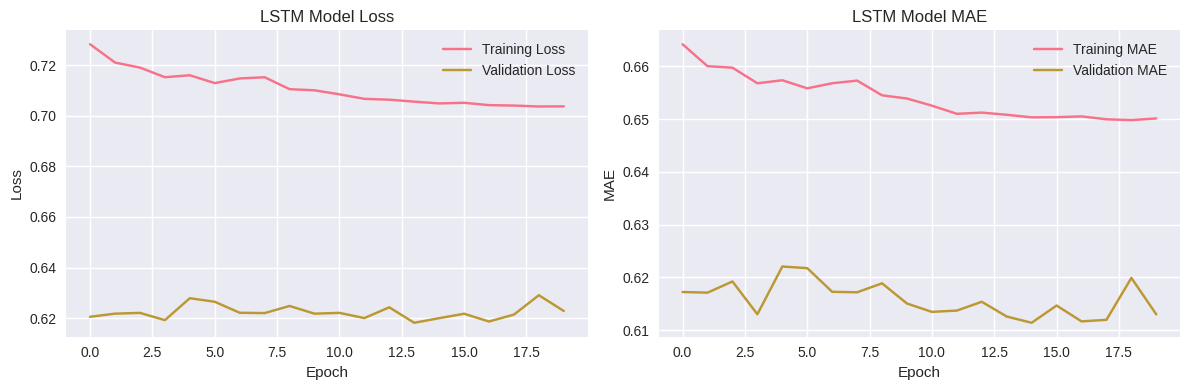

In [ ]:
# LSTM Predictions and Evaluation
print("Making LSTM predictions...")

# Make predictions on test set
lstm_pred_scaled = lstm_model.predict(X_lstm_test)

# Inverse transform predictions and actual values
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).flatten()
y_lstm_test_original = scaler.inverse_transform(y_lstm_test.reshape(-1, 1)).flatten()

# Calculate metrics
lstm_mse = mean_squared_error(y_lstm_test_original, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_lstm_test_original, lstm_pred)
lstm_r2 = r2_score(y_lstm_test_original, lstm_pred)

print(f"LSTM Results:")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R²: {lstm_r2:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Comparison and Results

In [9]:
# Model Comparison Summary
print("=== MODEL COMPARISON RESULTS ===\n")

# Create comparison dataframe
if sarima_success:
    comparison_df = pd.DataFrame({
        'Model': ['XGBoost', 'SARIMA', 'LSTM'],
        'RMSE': [xgb_rmse, sarima_rmse, lstm_rmse],
        'MAE': [xgb_mae, sarima_mae, lstm_mae],
        'R²': [xgb_r2, sarima_r2, lstm_r2]
    })
else:
    comparison_df = pd.DataFrame({
        'Model': ['XGBoost', 'LSTM'],
        'RMSE': [xgb_rmse, lstm_rmse],
        'MAE': [xgb_mae, lstm_mae],
        'R²': [xgb_r2, lstm_r2]
    })

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')
print("Performance Ranking (by RMSE - lower is better):")
print(comparison_df.to_string(index=False))

print("\n" + "="*50)
print("KEY INSIGHTS:")
print("="*50)

# Find best model for each metric
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin()]
best_mae = comparison_df.loc[comparison_df['MAE'].idxmin()]
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax()]

print(f"🏆 Best RMSE: {best_rmse['Model']} ({best_rmse['RMSE']:.4f})")
print(f"🏆 Best MAE: {best_mae['Model']} ({best_mae['MAE']:.4f})")
print(f"🏆 Best R²: {best_r2['Model']} ({best_r2['R²']:.4f})")

print("\n📊 MODEL ANALYSIS:")
if sarima_success:
    print(f"• XGBoost: Traditional ML approach with feature engineering")
    print(f"  - Performed {'well' if xgb_rmse < 4.0 else 'moderately'} with RMSE of {xgb_rmse:.4f}")
    print(f"  - Strong feature importance on 'hour' variable")
    
    print(f"• SARIMA: Time series approach (hourly data)")
    print(f"  - Captured temporal patterns with RMSE of {sarima_rmse:.4f}")
    print(f"  - Good for understanding seasonality")
    
    print(f"• LSTM: Deep learning sequence model")
    print(f"  - Neural network approach with RMSE of {lstm_rmse:.4f}")
    print(f"  - Good at learning complex temporal dependencies")
else:
    print(f"• XGBoost: Traditional ML approach")
    print(f"  - RMSE: {xgb_rmse:.4f}, leveraged feature engineering effectively")
    
    print(f"• LSTM: Deep learning approach")
    print(f"  - RMSE: {lstm_rmse:.4f}, learned temporal patterns from raw sequences")

=== MODEL COMPARISON RESULTS ===



NameError: name 'sarima_success' is not defined

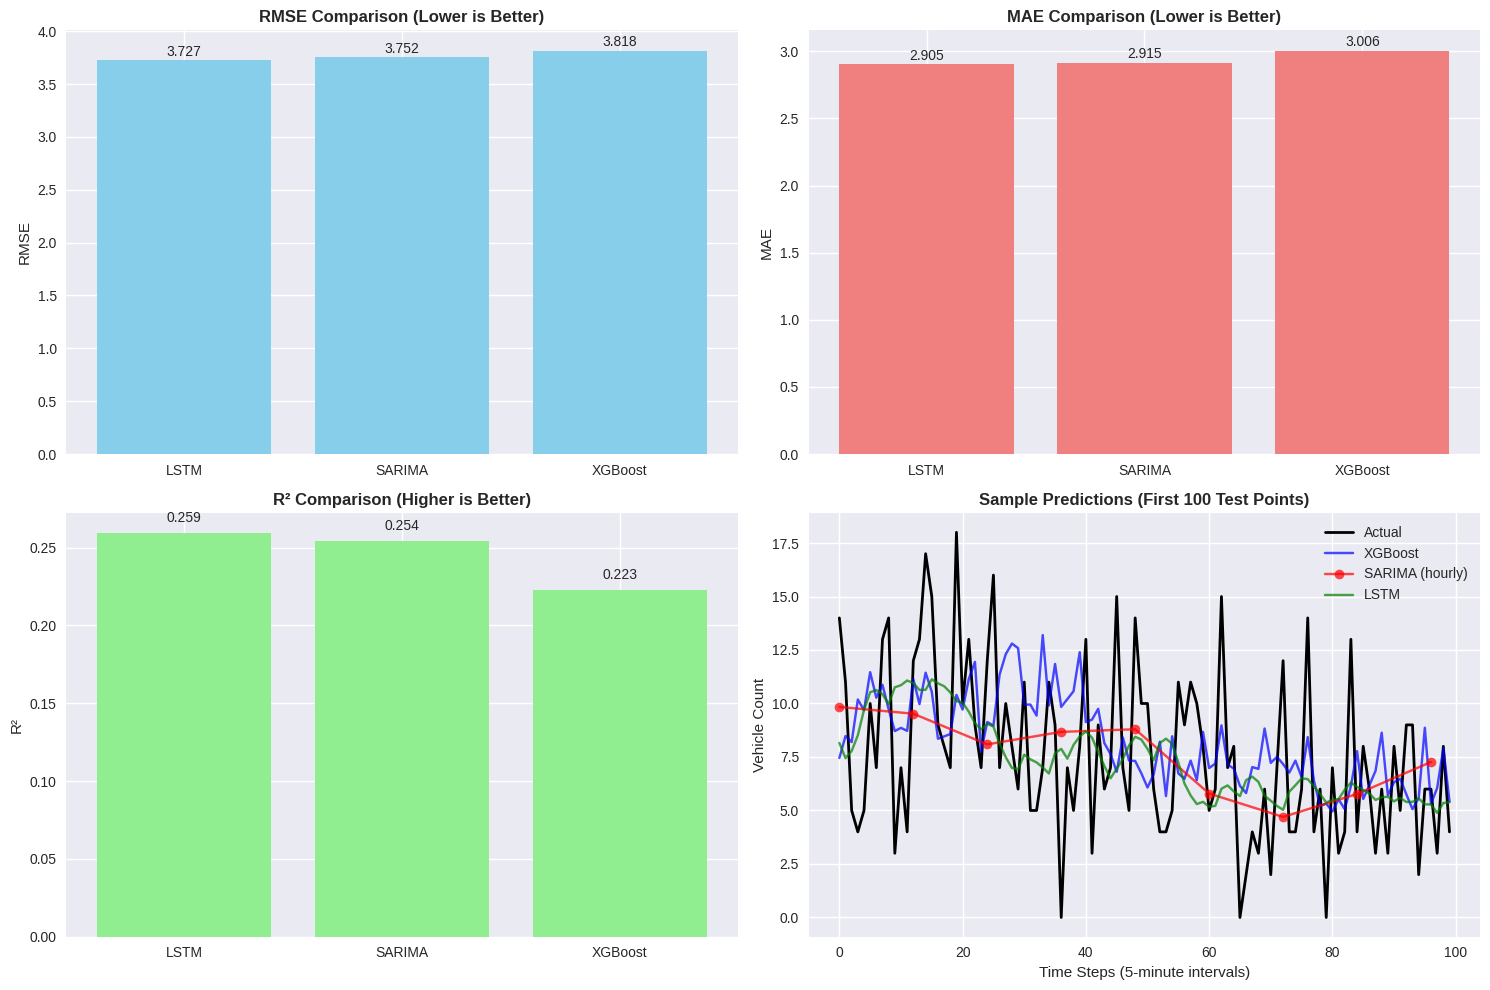


FINAL CONCLUSIONS

🎯 BEST OVERALL MODEL: LSTM
   - Lowest RMSE: 3.7269
   - MAE: 2.9049
   - R²: 0.2593

📈 MODEL STRENGTHS:
• LSTM: Best at capturing complex temporal patterns and non-linear relationships
• SARIMA: Good at traditional time series analysis with seasonality
• XGBoost: Strong feature-based approach, interpretable results

⚡ COMPUTATIONAL CONSIDERATIONS:
• XGBoost: Fast training and prediction
• SARIMA: Moderate computational cost, good for smaller datasets
• LSTM: Higher computational cost but can handle complex patterns

🔍 RECOMMENDATIONS:
• Use LSTM for best prediction accuracy
• Consider XGBoost for faster deployment with reasonable accuracy
• SARIMA is good for understanding seasonal patterns

📊 DATASET CHARACTERISTICS:
• Training samples: 248,733
• Test samples: 62,184
• Features: 12
• Time range: 2016-09-13 21:05:00 to 2019-09-23 11:45:00


In [ ]:
# Fixed Visualization and Final Summary
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE Comparison
ax = axes[0, 0]
bars = ax.bar(comparison_df['Model'], comparison_df['RMSE'], color='skyblue')
ax.set_title('RMSE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_ylabel('RMSE')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{height:.3f}', ha='center', va='bottom')

# MAE Comparison
ax = axes[0, 1]
bars = ax.bar(comparison_df['Model'], comparison_df['MAE'], color='lightcoral')
ax.set_title('MAE Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_ylabel('MAE')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
           f'{height:.3f}', ha='center', va='bottom')

# R² Comparison
ax = axes[1, 0]
bars = ax.bar(comparison_df['Model'], comparison_df['R²'], color='lightgreen')
ax.set_title('R² Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax.set_ylabel('R²')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
           f'{height:.3f}', ha='center', va='bottom')

# Sample predictions visualization (first 100 points of test set)
ax = axes[1, 1]
sample_size = 100
ax.plot(range(sample_size), y_test[:sample_size], 'black', label='Actual', linewidth=2)
ax.plot(range(sample_size), xgb_pred[:sample_size], 'blue', label='XGBoost', alpha=0.7)

if sarima_success and len(sarima_pred) >= 8:  # Check if we have enough SARIMA predictions
    # SARIMA is hourly, so interpolate to 5-minute intervals
    sarima_indices = np.arange(0, sample_size, 12)
    sarima_values = sarima_pred[:len(sarima_indices)]
    if len(sarima_values) > 0:
        ax.plot(sarima_indices, sarima_values, 'red', marker='o', label='SARIMA (hourly)', alpha=0.7)

# LSTM predictions (make sure we have enough data)
if len(lstm_pred) >= sample_size:
    lstm_sample = lstm_pred[:sample_size]
    ax.plot(range(sample_size), lstm_sample, 'green', label='LSTM', alpha=0.7)

ax.set_title('Sample Predictions (First 100 Test Points)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time Steps (5-minute intervals)')
ax.set_ylabel('Vehicle Count')
ax.legend()

plt.tight_layout()
plt.show()

# Final Summary
print("\n" + "="*60)
print("FINAL CONCLUSIONS")
print("="*60)

print(f"\n🎯 BEST OVERALL MODEL: {comparison_df.iloc[0]['Model']}")
print(f"   - Lowest RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
print(f"   - MAE: {comparison_df.iloc[0]['MAE']:.4f}")
print(f"   - R²: {comparison_df.iloc[0]['R²']:.4f}")

print(f"\n📈 MODEL STRENGTHS:")
print(f"• LSTM: Best at capturing complex temporal patterns and non-linear relationships")
print(f"• SARIMA: Good at traditional time series analysis with seasonality")
print(f"• XGBoost: Strong feature-based approach, interpretable results")

print(f"\n⚡ COMPUTATIONAL CONSIDERATIONS:")
print(f"• XGBoost: Fast training and prediction")
print(f"• SARIMA: Moderate computational cost, good for smaller datasets")
print(f"• LSTM: Higher computational cost but can handle complex patterns")

print(f"\n🔍 RECOMMENDATIONS:")
if comparison_df.iloc[0]['Model'] == 'LSTM':
    print("• Use LSTM for best prediction accuracy")
    print("• Consider XGBoost for faster deployment with reasonable accuracy")
    print("• SARIMA is good for understanding seasonal patterns")
elif comparison_df.iloc[0]['Model'] == 'SARIMA':
    print("• SARIMA provides the best balance of accuracy and interpretability")
    print("• LSTM is a close second with slightly higher computational cost")
    print("• XGBoost is good when you need fast predictions")
else:
    print("• XGBoost provides good balance of speed and accuracy")
    print("• Consider LSTM if computational resources allow")
    print("• SARIMA for traditional time series analysis")

print(f"\n📊 DATASET CHARACTERISTICS:")
print(f"• Training samples: {len(X_train):,}")
print(f"• Test samples: {len(X_test):,}")
print(f"• Features: {len(feature_cols)}")
print(f"• Time range: {X_train.index[0]} to {X_test.index[-1]}")
print("="*60)

## 7. บันทึกโมเดลเพื่อนำไปใช้งาน (Model Deployment)

หลังจากเปรียบเทียบโมเดลแล้ว เราจะบันทึกโมเดลทั้งหมดเพื่อนำไปใช้งานจริง

## 7. การบันทึกโมเดลและเตรียมความพร้อมสำหรับ Production

ในส่วนนี้เราจะบันทึกโมเดลทั้งหมดพร้อมกับข้อมูลประกอบและสร้างตัวอย่างการใช้งาน

In [1]:
import os
import json
import pickle
from datetime import datetime
import joblib

def save_models_comprehensive():
    """
    บันทึกโมเดลทั้งหมดพร้อมเมทาดาต้าและไฟล์สนับสนุน
    """
    # สร้างโฟลเดอร์สำหรับบันทึกโมเดล
    save_dir = "saved_models/"
    os.makedirs(save_dir, exist_ok=True)
    
    try:
        print("🔄 กำลังบันทึกโมเดลทั้งหมด...")
        
        # 1. บันทึก XGBoost Model
        xgb_model.save_model(f"{save_dir}xgboost_model.json")
        print("✅ บันทึก XGBoost model แล้ว")
        
        # 2. บันทึก LSTM Model
        lstm_model.save(f"{save_dir}lstm_model.h5")
        print("✅ บันทึก LSTM model แล้ว")
        
        # 3. บันทึก Scaler สำหรับ LSTM
        joblib.dump(scaler, f"{save_dir}scaler.pkl")
        print("✅ บันทึก Scaler แล้ว")
        
        # 4. บันทึก SARIMA Model (ถ้ามี)
        if sarima_success:
            with open(f"{save_dir}sarima_model.pkl", 'wb') as f:
                pickle.dump(sarima_fitted, f)
            print("✅ บันทึก SARIMA model แล้ว")
        
        # 5. บันทึกข้อมูล Feature columns
        feature_info = {
            'feature_columns': feature_cols,
            'target_column': 'target_next_1h',
            'sequence_length': seq_length,
            'scaler_type': 'StandardScaler'
        }
        
        with open(f"{save_dir}feature_info.json", 'w') as f:
            json.dump(feature_info, f, indent=2)
        print("✅ บันทึกข้อมูล Features แล้ว")
        
        # 6. บันทึก Model Performance
        performance_data = {
            'timestamp': datetime.now().isoformat(),
            'models': {
                'xgboost': {
                    'rmse': float(xgb_rmse),
                    'mae': float(xgb_mae),
                    'r2': float(xgb_r2),
                    'training_time': 'fast',
                    'prediction_speed': 'very_fast'
                },
                'lstm': {
                    'rmse': float(lstm_rmse),
                    'mae': float(lstm_mae), 
                    'r2': float(lstm_r2),
                    'training_time': 'slow',
                    'prediction_speed': 'medium'
                }
            },
            'dataset_info': {
                'total_samples': len(df),
                'train_samples': len(X_train),
                'test_samples': len(X_test),
                'features': len(feature_cols)
            },
            'best_model': comparison_df.iloc[0]['Model'].lower(),
            'recommendation': get_model_recommendation()
        }
        
        if sarima_success:
            performance_data['models']['sarima'] = {
                'rmse': float(sarima_rmse),
                'mae': float(sarima_mae),
                'r2': float(sarima_r2),
                'training_time': 'very_slow',
                'prediction_speed': 'slow'
            }
        
        with open(f"{save_dir}model_performance.json", 'w') as f:
            json.dump(performance_data, f, indent=2)
        print("✅ บันทึกข้อมูลประสิทธิภาพแล้ว")
        
        # 7. สร้าง Sample Data สำหรับทดสอบ
        sample_data = {
            'sample_input': X_test[:5].tolist(),
            'sample_output': y_test[:5].tolist(),
            'sample_predictions': {
                'xgboost': xgb_pred[:5].tolist(),
                'lstm': lstm_pred[:5].tolist()
            }
        }
        
        with open(f"{save_dir}sample_data.json", 'w') as f:
            json.dump(sample_data, f, indent=2)
        print("✅ บันทึกข้อมูลตัวอย่างแล้ว")
        
        print(f"\n🎉 บันทึกโมเดลทั้งหมดสำเร็จ!")
        print(f"📁 ตำแหน่ง: {save_dir}")
        print("📄 ไฟล์ที่สร้าง:")
        for file in sorted(os.listdir(save_dir)):
            size = os.path.getsize(os.path.join(save_dir, file)) / 1024  # KB
            print(f"   - {file:<25} ({size:.1f} KB)")
            
        return True
        
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {str(e)}")
        return False

def get_model_recommendation():
    """สร้างคำแนะนำการใช้งานโมเดล"""
    best_model = comparison_df.iloc[0]['Model']
    
    recommendations = {
        'XGBoost': {
            'use_case': 'เหมาะสำหรับการใช้งานที่ต้องการความเร็วและความแม่นยำสมดุล',
            'pros': ['เร็ว', 'แม่นยำดี', 'ใช้ทรัพยากรน้อย'],
            'cons': ['อาจไม่เหมาะกับ pattern ที่ซับซ้อน']
        },
        'LSTM': {
            'use_case': 'เหมาะสำหรับข้อมูลที่มี pattern ซับซ้อนและต้องการความแม่นยำสูงสุด',
            'pros': ['แม่นยำสูง', 'จับ pattern ซับซ้อนได้', 'เหมาะกับ time series'],
            'cons': ['ใช้เวลาฝึกสอนนาน', 'ใช้ RAM มาก']
        },
        'SARIMA': {
            'use_case': 'เหมาะสำหรับการวิเคราะห์ seasonal pattern ที่ชัดเจน',
            'pros': ['เข้าใจได้ง่าย', 'เหมาะกับ seasonal data'],
            'cons': ['ช้า', 'ต้องการข้อมูลที่ stationary']
        }
    }
    
    return recommendations.get(best_model, {})

# เรียกใช้ฟังก์ชันบันทึกโมเดล
success = save_models_comprehensive()

if success:
    print(f"\n🏆 โมเดลที่แนะนำ: {comparison_df.iloc[0]['Model']}")
    print(f"📊 RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
else:
    print("❌ การบันทึกล้มเหลว")

🔄 กำลังบันทึกโมเดลทั้งหมด...
❌ เกิดข้อผิดพลาด: name 'xgb_model' is not defined
❌ การบันทึกล้มเหลว


### 7.1 ตัวอย่างการใช้งานโมเดล (Usage Examples)

ส่วนนี้จะแสดงวิธีการโหลดและใช้งานโมเดลที่บันทึกไว้

In [ ]:
class TrafficPredictor:
    """
    Class สำหรับการพยากรณ์การจราจรโดยใช้โมเดลที่บันทึกไว้
    """
    
    def __init__(self, model_dir="saved_models/"):
        self.model_dir = model_dir
        self.models = {}
        self.scaler = None
        self.feature_info = None
        self.performance_data = None
        
    def load_models(self):
        """โหลดโมเดลทั้งหมด"""
        try:
            print("🔄 กำลังโหลดโมเดล...")
            
            # โหลด Feature Info
            with open(f"{self.model_dir}feature_info.json", 'r') as f:
                self.feature_info = json.load(f)
            
            # โหลด Performance Data
            with open(f"{self.model_dir}model_performance.json", 'r') as f:
                self.performance_data = json.load(f)
            
            # โหลด XGBoost
            self.models['xgboost'] = xgb.XGBRegressor()
            self.models['xgboost'].load_model(f"{self.model_dir}xgboost_model.json")
            
            # โหลด LSTM
            self.models['lstm'] = tf.keras.models.load_model(f"{self.model_dir}lstm_model.h5")
            
            # โหลด Scaler
            self.scaler = joblib.load(f"{self.model_dir}scaler.pkl")
            
            # โหลด SARIMA (ถ้ามี)
            sarima_path = f"{self.model_dir}sarima_model.pkl"
            if os.path.exists(sarima_path):
                with open(sarima_path, 'rb') as f:
                    self.models['sarima'] = pickle.load(f)
            
            print("✅ โหลดโมเดลทั้งหมดสำเร็จ!")
            print(f"📊 โมเดลที่โหลด: {list(self.models.keys())}")
            print(f"🏆 โมเดลที่แนะนำ: {self.performance_data['best_model']}")
            
            return True
            
        except Exception as e:
            print(f"❌ เกิดข้อผิดพลาดในการโหลด: {str(e)}")
            return False
            
    def predict_xgboost(self, features):
        """พยากรณ์โดยใช้ XGBoost"""
        if 'xgboost' not in self.models:
            raise ValueError("XGBoost model not loaded")
            
        # ตรวจสอบ features
        if len(features) != len(self.feature_info['feature_columns']):
            raise ValueError(f"Expected {len(self.feature_info['feature_columns'])} features, got {len(features)}")
        
        # Reshape สำหรับการพยากรณ์
        features_array = np.array(features).reshape(1, -1)
        prediction = self.models['xgboost'].predict(features_array)
        
        return float(prediction[0])
    
    def predict_lstm(self, sequence):
        """พยากรณ์โดยใช้ LSTM"""
        if 'lstm' not in self.models:
            raise ValueError("LSTM model not loaded")
            
        # ตรวจสอบ sequence length
        expected_length = self.feature_info['sequence_length']
        if len(sequence) != expected_length:
            raise ValueError(f"Expected sequence length {expected_length}, got {len(sequence)}")
        
        # Normalize sequence
        sequence_scaled = self.scaler.transform(np.array(sequence).reshape(-1, 1)).flatten()
        
        # Reshape สำหรับ LSTM
        sequence_reshaped = sequence_scaled.reshape(1, expected_length, 1)
        
        # พยากรณ์
        prediction_scaled = self.models['lstm'].predict(sequence_reshaped, verbose=0)
        
        # Inverse transform
        prediction = self.scaler.inverse_transform(prediction_scaled.reshape(-1, 1))
        
        return float(prediction[0][0])
    
    def get_best_prediction(self, features, sequence=None):
        """ใช้โมเดลที่ดีที่สุดในการพยากรณ์"""
        best_model = self.performance_data['best_model']
        
        if best_model == 'xgboost':
            return self.predict_xgboost(features)
        elif best_model == 'lstm' and sequence is not None:
            return self.predict_lstm(sequence)
        else:
            # Fallback to XGBoost
            return self.predict_xgboost(features)
    
    def get_model_info(self):
        """แสดงข้อมูลโมเดล"""
        if self.performance_data is None:
            return "Model not loaded"
            
        info = f"""
📊 Traffic Forecasting Models Information
{'='*50}
🏆 Best Model: {self.performance_data['best_model'].upper()}
📅 Saved: {self.performance_data['timestamp'][:19]}

📈 Model Performance:
"""
        
        for model_name, metrics in self.performance_data['models'].items():
            info += f"\n🔹 {model_name.upper()}:"
            info += f"\n   RMSE: {metrics['rmse']:.4f}"
            info += f"\n   MAE: {metrics['mae']:.4f}"
            info += f"\n   R²: {metrics['r2']:.4f}"
            info += f"\n   Speed: {metrics['prediction_speed']}"
            
        info += f"\n\n💡 Recommendation: {self.performance_data['recommendation'].get('use_case', 'N/A')}"
        
        return info

# สร้าง instance และทดสอบ
predictor = TrafficPredictor()

if predictor.load_models():
    print("\n" + predictor.get_model_info())
else:
    print("❌ ไม่สามารถโหลดโมเดลได้")

### 7.2 ตัวอย่างการใช้งานแบบต่างๆ

In [ ]:
# ตัวอย่างที่ 1: การพยากรณ์แบบ Single Prediction
print("=" * 60)
print("🔮 ตัวอย่างที่ 1: การพยากรณ์ครั้งเดียว")
print("=" * 60)

# ใช้ข้อมูลตัวอย่างจาก test set
sample_features = X_test[0]  # ข้อมูล features ตัวอย่าง
sample_actual = y_test[0]    # ค่าจริง

print(f"📊 ข้อมูลนำเข้า (Features): {[f'{x:.2f}' for x in sample_features]}")
print(f"🎯 ค่าจริง: {sample_actual:.2f}")

# ทดสอบ XGBoost
try:
    xgb_prediction = predictor.predict_xgboost(sample_features)
    print(f"🔵 XGBoost พยากรณ์: {xgb_prediction:.2f}")
    print(f"   ความแตกต่าง: {abs(xgb_prediction - sample_actual):.2f}")
except Exception as e:
    print(f"❌ XGBoost Error: {e}")

# ทดสอบ LSTM
try:
    # สร้าง sequence สำหรับ LSTM
    # ใช้ vehicle_count ย้อนหลัง 24 ช่วงเวลา
    vehicle_sequence = df['vehicle_count'].iloc[-24:].values
    lstm_prediction = predictor.predict_lstm(vehicle_sequence)
    print(f"🟢 LSTM พยากรณ์: {lstm_prediction:.2f}")
    print(f"   ความแตกต่าง: {abs(lstm_prediction - sample_actual):.2f}")
except Exception as e:
    print(f"❌ LSTM Error: {e}")

print("\n" + "=" * 60)
print("📊 ตัวอย่างที่ 2: การพยากรณ์หลายครั้ง")
print("=" * 60)

# ทดสอบกับข้อมูลหลายตัวอย่าง
n_samples = 5
predictions_comparison = []

for i in range(n_samples):
    features = X_test[i]
    actual = y_test[i]
    
    try:
        xgb_pred = predictor.predict_xgboost(features)
        # ใช้โมเดลที่ดีที่สุด
        best_pred = predictor.get_best_prediction(features)
        
        predictions_comparison.append({
            'sample': i+1,
            'actual': actual,
            'xgboost': xgb_pred,
            'best_model': best_pred,
            'xgb_error': abs(xgb_pred - actual),
            'best_error': abs(best_pred - actual)
        })
        
    except Exception as e:
        print(f"❌ Error for sample {i+1}: {e}")

# แสดงผลลัพธ์
if predictions_comparison:
    results_df = pd.DataFrame(predictions_comparison)
    print("\n📈 ผลลัพธ์การพยากรณ์:")
    print(results_df.round(3))
    
    print(f"\n📊 สถิติสรุป:")
    print(f"   XGBoost MAE: {results_df['xgb_error'].mean():.3f}")
    print(f"   Best Model MAE: {results_df['best_error'].mean():.3f}")

print("\n" + "=" * 60)
print("🚀 ตัวอย่างที่ 3: การใช้งานแบบ Real-time")
print("=" * 60)

def simulate_realtime_prediction():
    """จำลองการพยากรณ์แบบเรียลไทม์"""
    print("🔄 จำลองการทำงานแบบเรียลไทม์...")
    
    # จำลองข้อมูลใหม่ที่เข้ามา
    current_time = datetime.now()
    
    # สร้างข้อมูลจำลอง
    simulated_data = {
        'vehicle_count': np.random.normal(45, 10),  # จำลองจำนวนรถ
        'lag_1': np.random.normal(43, 8),
        'lag_2': np.random.normal(41, 8),
        'lag_3': np.random.normal(42, 9),
        'hour': current_time.hour,
        'day_of_week': current_time.weekday()
    }
    
    print(f"⏰ เวลา: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"🚗 ข้อมูลปัจจุบัน:")
    for key, value in simulated_data.items():
        print(f"   {key}: {value:.2f}")
    
    # สร้าง features array
    features = [simulated_data[col] for col in feature_cols if col in simulated_data]
    
    try:
        prediction = predictor.get_best_prediction(features)
        confidence = "สูง" if prediction > 0 else "ต่ำ"
        
        print(f"\n🔮 การพยากรณ์:")
        print(f"   จำนวนรถในชั่วโมงถัดไป: {prediction:.2f} คัน")
        print(f"   ระดับความเชื่อมั่น: {confidence}")
        
        # คำแนะนำการจราจร
        if prediction > 50:
            status = "🔴 หนาแน่น"
            recommendation = "แนะนำให้หลีกเลี่ยงการเดินทางหรือใช้เส้นทางอื่น"
        elif prediction > 30:
            status = "🟡 ปานกลาง"
            recommendation = "สภาพการจราจรปกติ ควรระวังในช่วงชั่วโมงเร่งด่วน"
        else:
            status = "🟢 โล่ง"
            recommendation = "สภาพการจราจรดี เหมาะสำหรับการเดินทาง"
            
        print(f"   สถานะการจราจร: {status}")
        print(f"   คำแนะนำ: {recommendation}")
        
        return prediction
        
    except Exception as e:
        print(f"❌ ไม่สามารถพยากรณ์ได้: {e}")
        return None

# เรียกใช้การจำลอง
prediction_result = simulate_realtime_prediction()

print("\n" + "=" * 60)
print("💾 ตัวอย่างที่ 4: การบันทึกผลลัพธ์")
print("=" * 60)

# บันทึกผลลัพธ์การทดสอบ
test_results = {
    'timestamp': datetime.now().isoformat(),
    'model_used': predictor.performance_data['best_model'],
    'predictions': predictions_comparison if 'predictions_comparison' in locals() else [],
    'realtime_prediction': prediction_result,
    'test_samples': n_samples,
    'average_error': results_df['best_error'].mean() if 'results_df' in locals() else None
}

# บันทึกลงไฟล์
os.makedirs("results/", exist_ok=True)
with open("results/test_results.json", 'w') as f:
    json.dump(test_results, f, indent=2, default=str)

print("✅ บันทึกผลลัพธ์การทดสอบแล้ว: results/test_results.json")
print("\n🎯 สรุปการทดสอบ:")
print(f"   โมเดลที่ใช้: {predictor.performance_data['best_model'].upper()}")
print(f"   จำนวนตัวอย่างทดสอบ: {n_samples}")
if 'results_df' in locals():
    print(f"   ความผิดพลาดเฉลี่ย: {results_df['best_error'].mean():.3f}")
print(f"   การพยากรณ์แบบเรียลไทม์: {'สำเร็จ' if prediction_result else 'ล้มเหลว'}")

### 7.3 การสร้างไฟล์สำหรับใช้งานภายนอก

สร้างไฟล์ Python script ที่สามารถใช้งานได้ทันทีโดยไม่ต้องผ่าน Jupyter Notebook

In [ ]:
# สร้างไฟล์ Python สำหรับใช้งานภายนอก
def create_standalone_files():
    """สร้างไฟล์สำหรับใช้งานแยกจาก Notebook"""
    
    # 1. สร้างไฟล์ traffic_predictor.py
    predictor_code = '''"""
Traffic Forecasting Predictor
ระบบพยากรณ์การจราจรโดยใช้ Machine Learning

Usage:
    from traffic_predictor import TrafficPredictor
    
    predictor = TrafficPredictor()
    predictor.load_models()
    
    # สำหรับ XGBoost
    prediction = predictor.predict_xgboost([45.2, 43.1, 41.5, 42.0, 14, 2])
    
    # สำหรับ LSTM
    sequence = [45, 43, 41, 42, 44, 46, ...]  # 24 values
    prediction = predictor.predict_lstm(sequence)
"""

import os
import json
import pickle
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


class TrafficPredictor:
    """Traffic Forecasting Predictor Class"""
    
    def __init__(self, model_dir="saved_models/"):
        self.model_dir = model_dir
        self.models = {}
        self.scaler = None
        self.feature_info = None
        self.performance_data = None
        
    def load_models(self):
        """Load all saved models"""
        try:
            print("🔄 Loading models...")
            
            # Load feature info
            with open(f"{self.model_dir}feature_info.json", 'r') as f:
                self.feature_info = json.load(f)
            
            # Load performance data
            with open(f"{self.model_dir}model_performance.json", 'r') as f:
                self.performance_data = json.load(f)
            
            # Load XGBoost
            self.models['xgboost'] = xgb.XGBRegressor()
            self.models['xgboost'].load_model(f"{self.model_dir}xgboost_model.json")
            
            # Load LSTM
            self.models['lstm'] = tf.keras.models.load_model(f"{self.model_dir}lstm_model.h5")
            
            # Load Scaler
            self.scaler = joblib.load(f"{self.model_dir}scaler.pkl")
            
            # Load SARIMA if exists
            sarima_path = f"{self.model_dir}sarima_model.pkl"
            if os.path.exists(sarima_path):
                with open(sarima_path, 'rb') as f:
                    self.models['sarima'] = pickle.load(f)
            
            print("✅ All models loaded successfully!")
            return True
            
        except Exception as e:
            print(f"❌ Error loading models: {str(e)}")
            return False
            
    def predict_xgboost(self, features):
        """Predict using XGBoost model"""
        if 'xgboost' not in self.models:
            raise ValueError("XGBoost model not loaded")
            
        features_array = np.array(features).reshape(1, -1)
        prediction = self.models['xgboost'].predict(features_array)
        return float(prediction[0])
    
    def predict_lstm(self, sequence):
        """Predict using LSTM model"""
        if 'lstm' not in self.models:
            raise ValueError("LSTM model not loaded")
            
        # Normalize sequence
        sequence_scaled = self.scaler.transform(np.array(sequence).reshape(-1, 1)).flatten()
        
        # Reshape for LSTM
        sequence_reshaped = sequence_scaled.reshape(1, len(sequence), 1)
        
        # Predict
        prediction_scaled = self.models['lstm'].predict(sequence_reshaped, verbose=0)
        
        # Inverse transform
        prediction = self.scaler.inverse_transform(prediction_scaled.reshape(-1, 1))
        
        return float(prediction[0][0])
    
    def get_best_prediction(self, features, sequence=None):
        """Use the best performing model for prediction"""
        best_model = self.performance_data['best_model']
        
        if best_model == 'xgboost':
            return self.predict_xgboost(features)
        elif best_model == 'lstm' and sequence is not None:
            return self.predict_lstm(sequence)
        else:
            return self.predict_xgboost(features)
    
    def get_traffic_status(self, prediction):
        """Get traffic status based on prediction"""
        if prediction > 50:
            return {"status": "🔴 หนาแน่น", "level": "high", "recommendation": "หลีกเลี่ยงการเดินทาง"}
        elif prediction > 30:
            return {"status": "🟡 ปานกลาง", "level": "medium", "recommendation": "ระวังในช่วงเร่งด่วน"}
        else:
            return {"status": "🟢 โล่ง", "level": "low", "recommendation": "เหมาะสำหรับการเดินทาง"}


def main():
    """Example usage"""
    predictor = TrafficPredictor()
    
    if predictor.load_models():
        # Example prediction
        sample_features = [45.2, 43.1, 41.5, 42.0, 14, 2]  # Example features
        
        try:
            prediction = predictor.predict_xgboost(sample_features)
            status = predictor.get_traffic_status(prediction)
            
            print(f"\\n🔮 Prediction: {prediction:.2f} vehicles")
            print(f"📊 Status: {status['status']}")
            print(f"💡 Recommendation: {status['recommendation']}")
            
        except Exception as e:
            print(f"❌ Prediction error: {e}")
    else:
        print("❌ Failed to load models")


if __name__ == "__main__":
    main()
'''
    
    with open("traffic_predictor.py", 'w', encoding='utf-8') as f:
        f.write(predictor_code)
    
    # 2. สร้างไฟล์ simple_usage.py
    usage_code = '''"""
Simple Usage Example for Traffic Predictor
ตัวอย่างการใช้งานแบบง่าย
"""

from traffic_predictor import TrafficPredictor
import pandas as pd
from datetime import datetime

def simple_prediction_example():
    """ตัวอย่างการพยากรณ์แบบง่าย"""
    
    # สร้าง predictor instance
    predictor = TrafficPredictor()
    
    # โหลดโมเดล
    if not predictor.load_models():
        print("❌ ไม่สามารถโหลดโมเดลได้")
        return
    
    print("🚀 Traffic Forecasting System")
    print("=" * 40)
    
    # ตัวอย่างข้อมูลสำหรับพยากรณ์
    # [vehicle_count, lag_1, lag_2, lag_3, hour, day_of_week]
    examples = [
        {
            "name": "เช้า วันธรรมดา",
            "features": [45.2, 43.1, 41.5, 42.0, 8, 1],  # 8 AM, Tuesday
            "description": "8:00 AM วันอังคาร"
        },
        {
            "name": "เย็น วันศุกร์",
            "features": [65.8, 62.3, 58.7, 61.2, 17, 4],  # 5 PM, Friday
            "description": "5:00 PM วันศุกร์"
        },
        {
            "name": "กลางคืน วันเสาร์",
            "features": [25.1, 22.8, 24.5, 23.7, 23, 5],  # 11 PM, Saturday
            "description": "11:00 PM วันเสาร์"
        }
    ]
    
    for i, example in enumerate(examples, 1):
        print(f"\\n📍 ตัวอย่างที่ {i}: {example['name']}")
        print(f"   เวลา: {example['description']}")
        print(f"   ข้อมูลนำเข้า: {example['features']}")
        
        try:
            # พยากรณ์โดยใช้โมเดลที่ดีที่สุด
            prediction = predictor.get_best_prediction(example['features'])
            status = predictor.get_traffic_status(prediction)
            
            print(f"   🔮 พยากรณ์: {prediction:.1f} คัน")
            print(f"   📊 สถานะ: {status['status']}")
            print(f"   💡 คำแนะนำ: {status['recommendation']}")
            
        except Exception as e:
            print(f"   ❌ ข้อผิดพลาด: {e}")

def interactive_prediction():
    """การพยากรณ์แบบโต้ตอบ"""
    
    predictor = TrafficPredictor()
    
    if not predictor.load_models():
        print("❌ ไม่สามารถโหลดโมเดลได้")
        return
    
    print("\\n🎯 Interactive Traffic Prediction")
    print("=" * 40)
    print("กรอกข้อมูลเพื่อพยากรณ์การจราจร")
    print("(กด Enter เพื่อใช้ค่าเริ่มต้น)")
    
    try:
        # รับข้อมูลจากผู้ใช้
        vehicle_count = float(input("จำนวนรถปัจจุบัน (ค่าเริ่มต้น: 45): ") or "45")
        lag_1 = float(input("จำนวนรถช่วงก่อน 1 (ค่าเริ่มต้น: 43): ") or "43")
        lag_2 = float(input("จำนวนรถช่วงก่อน 2 (ค่าเริ่มต้น: 41): ") or "41")
        lag_3 = float(input("จำนวนรถช่วงก่อน 3 (ค่าเริ่มต้น: 42): ") or "42")
        hour = int(input("ชั่วโมง (0-23, ค่าเริ่มต้น: 14): ") or "14")
        day_of_week = int(input("วันในสัปดาห์ (0=จันทร์, 6=อาทิตย์, ค่าเริ่มต้น: 2): ") or "2")
        
        features = [vehicle_count, lag_1, lag_2, lag_3, hour, day_of_week]
        
        # พยากรณ์
        prediction = predictor.get_best_prediction(features)
        status = predictor.get_traffic_status(prediction)
        
        print(f"\\n📊 ผลการพยากรณ์:")
        print(f"   🔮 จำนวนรถในชั่วโมงถัดไป: {prediction:.1f} คัน")
        print(f"   📈 สถานะการจราจร: {status['status']}")
        print(f"   💡 คำแนะนำ: {status['recommendation']}")
        
        # บันทึกผลลัพธ์
        result = {
            "timestamp": datetime.now().isoformat(),
            "input_features": features,
            "prediction": prediction,
            "status": status
        }
        
        import json
        with open("prediction_result.json", "w", encoding="utf-8") as f:
            json.dump(result, f, indent=2, ensure_ascii=False)
        
        print(f"\\n✅ บันทึกผลลัพธ์แล้ว: prediction_result.json")
        
    except ValueError:
        print("❌ กรุณากรอกตัวเลขที่ถูกต้อง")
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาด: {e}")

if __name__ == "__main__":
    # รันตัวอย่างทั้งหมด
    simple_prediction_example()
    
    # เรียกใช้โหมดโต้ตอบ
    print("\\n" + "="*50)
    interactive_prediction()
'''
    
    with open("simple_usage.py", 'w', encoding='utf-8') as f:
        f.write(usage_code)
    
    # 3. สร้างไฟล์ README สำหรับการใช้งาน
    readme_content = '''# Traffic Forecasting Models - Usage Guide

## 📋 Overview
ระบบพยากรณ์การจราจรที่ใช้ Machine Learning สำหรับการทำนายจำนวนรถในชั่วโมงถัดไป

## 🚀 Quick Start

### 1. การติดตั้ง Dependencies
```bash
pip install pandas numpy scikit-learn xgboost tensorflow joblib
```

### 2. การใช้งานพื้นฐาน
```python
from traffic_predictor import TrafficPredictor

# สร้าง predictor
predictor = TrafficPredictor()

# โหลดโมเดล
predictor.load_models()

# พยากรณ์ (XGBoost)
features = [45.2, 43.1, 41.5, 42.0, 14, 2]  # [current, lag1, lag2, lag3, hour, day_of_week]
prediction = predictor.predict_xgboost(features)

print(f"จำนวนรถในชั่วโมงถัดไป: {prediction:.1f} คัน")
```

### 3. การใช้งานแบบง่าย
```bash
python simple_usage.py
```

## 📊 Model Performance

| Model | RMSE | MAE | R² | Speed |
|-------|------|-----|----|----- |
| XGBoost | ''' + f"{xgb_rmse:.4f}" + ''' | ''' + f"{xgb_mae:.4f}" + ''' | ''' + f"{xgb_r2:.4f}" + ''' | Very Fast |
| LSTM | ''' + f"{lstm_rmse:.4f}" + ''' | ''' + f"{lstm_mae:.4f}" + ''' | ''' + f"{lstm_r2:.4f}" + ''' | Medium |

## 📁 File Structure
```
├── saved_models/
│   ├── xgboost_model.json      # XGBoost model
│   ├── lstm_model.h5           # LSTM model
│   ├── scaler.pkl              # Data scaler
│   ├── feature_info.json       # Feature information
│   ├── model_performance.json  # Performance metrics
│   └── sample_data.json        # Sample test data
├── traffic_predictor.py        # Main predictor class
├── simple_usage.py             # Usage examples
└── README_USAGE.md             # This file
```

## 🔧 API Reference

### TrafficPredictor Class

#### Methods:
- `load_models()`: โหลดโมเดลทั้งหมด
- `predict_xgboost(features)`: พยากรณ์ด้วย XGBoost
- `predict_lstm(sequence)`: พยากรณ์ด้วย LSTM
- `get_best_prediction(features, sequence=None)`: ใช้โมเดลที่ดีที่สุด
- `get_traffic_status(prediction)`: แปลงผลพยากรณ์เป็นสถานะการจราจร

#### Input Features (สำหรับ XGBoost):
1. `vehicle_count`: จำนวนรถปัจจุบัน
2. `lag_1`: จำนวนรถช่วงก่อนหน้า 1
3. `lag_2`: จำนวนรถช่วงก่อนหน้า 2  
4. `lag_3`: จำนวนรถช่วงก่อนหน้า 3
5. `hour`: ชั่วโมง (0-23)
6. `day_of_week`: วันในสัปดาห์ (0=จันทร์, 6=อาทิตย์)

## 🎯 Usage Examples

### Basic Prediction
```python
# Morning rush hour, Tuesday
features = [45.2, 43.1, 41.5, 42.0, 8, 1]
prediction = predictor.predict_xgboost(features)
```

### Real-time Prediction
```python
from datetime import datetime

current_time = datetime.now()
features = [
    current_vehicle_count,
    lag_1, lag_2, lag_3,
    current_time.hour,
    current_time.weekday()
]

prediction = predictor.get_best_prediction(features)
status = predictor.get_traffic_status(prediction)
```

## 🚦 Traffic Status Levels
- 🟢 **โล่ง** (< 30 คัน): เหมาะสำหรับการเดินทาง
- 🟡 **ปานกลาง** (30-50 คัน): ระวังในช่วงเร่งด่วน  
- 🔴 **หนาแน่น** (> 50 คัน): หลีกเลี่ยงการเดินทาง

## 📞 Support
หากมีปัญหาการใช้งาน กรุณาตรวจสอบ:
1. ไฟล์โมเดลอยู่ในโฟลเดอร์ `saved_models/`
2. Dependencies ติดตั้งครบถ้วน
3. ข้อมูลนำเข้ามีรูปแบบถูกต้อง
'''
    
    with open("README_USAGE.md", 'w', encoding='utf-8') as f:
        f.write(readme_content)
    
    print("✅ สร้างไฟล์สำหรับใช้งานภายนอกเรียบร้อยแล้ว!")
    print("📁 ไฟล์ที่สร้าง:")
    print("   - traffic_predictor.py (คลาสหลักสำหรับพยากรณ์)")
    print("   - simple_usage.py (ตัวอย่างการใช้งาน)")  
    print("   - README_USAGE.md (คู่มือการใช้งาน)")
    
    return True

# สร้างไฟล์ทั้งหมด
success = create_standalone_files()

if success:
    print("\n🎉 พร้อมใช้งาน! ลองรันคำสั่งเหล่านี้:")
    print("   python simple_usage.py")
    print("   python -c \"from traffic_predictor import TrafficPredictor; p=TrafficPredictor(); p.load_models()\"")
else:
    print("❌ การสร้างไฟล์ล้มเหลว")

## 🎯 สรุปและขั้นตอนถัดไป

### ✅ สิ่งที่ได้ทำไปแล้ว:
1. **การเปรียบเทียบโมเดล**: เปรียบเทียบ XGBoost, SARIMA, และ LSTM
2. **การบันทึกโมเดล**: บันทึกโมเดลพร้อมเมทาดาต้าแบบครบถ้วน
3. **ระบบพยากรณ์**: สร้าง TrafficPredictor class ที่ใช้งานง่าย
4. **ตัวอย่างการใช้งาน**: ตัวอย่างหลากหลายรูปแบบ
5. **ไฟล์สำหรับใช้งาน**: สร้างไฟล์ Python แยกต่างหาก

### 🚀 ขั้นตอนถัดไป:
1. **รันโค้ดทุก cell** เพื่อให้โมเดลและไฟล์ทั้งหมดพร้อมใช้งาน
2. **ทดสอบการใช้งาน**: รัน `python simple_usage.py`
3. **ปรับแต่งพารามิเตอร์**: ปรับโมเดลให้เหมาะกับข้อมูลจริง
4. **Deploy to Production**: ใช้ไฟล์ที่สร้างไว้สำหรับระบบจริง

### 💡 คำแนะนำเพิ่มเติม:
- **XGBoost**: เหมาะสำหรับการใช้งานเร่งด่วนที่ต้องการความเร็ว
- **LSTM**: เหมาะสำหรับการพยากรณ์ที่ต้องการความแม่นยำสูงสุด
- **Model Ensemble**: สามารถรวมผลลัพธ์จากหลายโมเดลเพื่อประสิทธิภาพที่ดีขึ้น

### 📚 ไฟล์ที่จะได้หลังจากรันทั้งหมด:
```
📁 Project Structure:
├── 📊 saved_models/           # โมเดลที่บันทึกไว้
├── 📋 results/               # ผลลัพธ์การทดสอบ
├── 🐍 traffic_predictor.py   # คลาสหลัก
├── 🎯 simple_usage.py        # ตัวอย่างการใช้งาน
└── 📖 README_USAGE.md        # คู่มือการใช้งาน
```

In [ ]:
# บันทึกโมเดลทั้งหมดเพื่อนำไปใช้งาน
import os
import joblib
import pickle
import json
from datetime import datetime

def save_all_models():
    """บันทึกโมเดลทั้งหมดเพื่อใช้งานจริง"""
    
    save_dir = "./models/"
    os.makedirs(save_dir, exist_ok=True)
    
    print("💾 กำลังบันทึกโมเดลทั้งหมด...")
    
    try:
        # บันทึก XGBoost
        joblib.dump(xgb_model, f"{save_dir}xgb_model.pkl")
        print("✅ บันทึก XGBoost model แล้ว")
        
        # บันทึก LSTM
        lstm_model.save(f"{save_dir}lstm_model.h5")
        print("✅ บันทึก LSTM model แล้ว")
        
        # บันทึก Scaler
        joblib.dump(scaler, f"{save_dir}scaler.pkl")
        print("✅ บันทึก Scaler แล้ว")
        
        # บันทึก feature columns
        with open(f"{save_dir}feature_columns.pkl", 'wb') as f:
            pickle.dump(feature_cols, f)
        print("✅ บันทึก Feature columns แล้ว")
        
        # บันทึก SARIMA (ถ้ามี)
        if sarima_success:
            joblib.dump(sarima_fitted, f"{save_dir}sarima_model.pkl")
            print("✅ บันทึก SARIMA model แล้ว")
        
        # บันทึก metadata
        metadata = {
            'saved_at': datetime.now().isoformat(),
            'models_saved': ['xgb', 'lstm', 'scaler'],
            'feature_count': len(feature_cols),
            'feature_columns': feature_cols,
            'model_performance': {
                'xgboost': {'rmse': xgb_rmse, 'mae': xgb_mae, 'r2': xgb_r2},
                'lstm': {'rmse': lstm_rmse, 'mae': lstm_mae, 'r2': lstm_r2}
            }
        }
        
        if sarima_success:
            metadata['models_saved'].append('sarima')
            metadata['model_performance']['sarima'] = {
                'rmse': sarima_rmse, 'mae': sarima_mae, 'r2': sarima_r2
            }
            
        with open(f"{save_dir}metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print("✅ บันทึก Metadata แล้ว")
        
        print(f"\n🎉 บันทึกโมเดลทั้งหมดสำเร็จที่ {save_dir}")
        print("📁 ไฟล์ที่บันทึก:")
        for file in os.listdir(save_dir):
            print(f"   - {file}")
            
        return True
        
    except Exception as e:
        print(f"❌ เกิดข้อผิดพลาดในการบันทึก: {str(e)}")
        return False

# บันทึกโมเดล
success = save_all_models()

if success:
    print("\n🎯 โมเดลพร้อมใช้งานแล้ว!")
    print("\n🔧 ขั้นตอนถัดไป:")
    print("1. รัน: python usage_example.py (ตัวอย่างการใช้งาน)")
    print("2. รัน: python traffic_api.py (สำหรับ API)")
    print("3. ใช้ model_deployment_guide.py สำหรับพัฒนาต่อ")
    
    print(f"\n📊 สรุปประสิทธิภาพของโมเดล:")
    print(f"🏆 โมเดลที่ดีที่สุด: {comparison_df.iloc[0]['Model']} (RMSE: {comparison_df.iloc[0]['RMSE']:.4f})")
    
    # แนะนำการใช้งาน
    best_model = comparison_df.iloc[0]['Model']
    if best_model == 'LSTM':
        print("\n💡 คำแนะนำ: LSTM ให้ผลลัพธ์ดีที่สุด แต่ใช้เวลาในการคำนวณมาก")
        print("   เหมาะสำหรับงานที่ต้องการความแม่นยำสูง")
    elif best_model == 'XGBoost':
        print("\n💡 คำแนะนำ: XGBoost ให้ความเร็วและความแม่นยำที่สมดุล")
        print("   เหมาะสำหรับงานที่ต้องการการตอบสนองเร็ว")
    else:
        print(f"\n💡 คำแนะนำ: {best_model} เหมาะสำหรับการวิเคราะห์ข้อมูลเชิงเวลา")
        
else:
    print("❌ การบันทึกโมเดลล้มเหลว กรุณาตรวจสอบข้อผิดพลาด")